# Fig 6: TS diagram: 2x2, NNI and LC for MHW and MCS


In [2]:
#%matplotlib widget 
%matplotlib inline

import sys
sys.path.append("../")  # adds upper level to working directory
# somehow the other way does not work
from utils.orca_utilities import orca_index,deseason_month,anomaly,mean_LC_width,load_orca_EIO,deseason
from utils.mhw_detection import detect_events

import matplotlib.pyplot as plt
import cmocean as cmo
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import calendar
import string
import seawater as sw
import matplotlib.dates as mdates

################################
# path to save plots
plotsave = './plots/'

# Load data

In [4]:
# full model data (EIO)
#  load run by run and delete old file, as it seems as if influences speed
[k003ts,_,_] = load_orca_EIO('K003.hindcast')
# [k004ts,k004u,k004v] = load_orca_EIO('K004.thermhal90')
# [k005ts,k005u,k005v] = load_orca_EIO('K005.wind90')

# NNI 
k003f = xr.open_dataset('../data/NNI_noanom_K003_22S_32S_110E_117W.nc')
k003 = xr.open_dataset('../data/NNI_K003_22S_32S_110E_117W.nc')

# Leeuwin Current
# load saved sata
LC_k003 = xr.open_dataset('../data/LC_k003.nc')
LC_k004 = xr.open_dataset('../data/LC_k004.nc')
LC_k005 = xr.open_dataset('../data/LC_k005.nc')

# detect events
# define threshold
pval = 10
bool_mhw,bool_mcw = detect_events(k003,pval,0,'monthly')

calculate monthly threshold


# TS diagram

In [5]:
# deseason LC data
LC_dseas=deseason(LC_k003)

# calculate density
salm,tempm = np.meshgrid(np.arange(20,40,0.1),np.arange(0,34,1))
dens = sw.pden(salm,tempm,0,0)-1000 # seems to be the same as gsw
inc = 10
depth = 800
# which lat range in LC
latrange = slice(-32,-22)


# create time-mean fields for background reference 
# sal_mean = k003ts['vosaline'].mean('time_counter')
# temp_mean = k003ts['votemper'].mean('time_counter')

# # save as netcdf
# sal_mean.to_netcdf('../k003_sal_time_mean.nc')
# temp_mean.to_netcdf('../k003_temp_time_mean.nc')

# load saved files
sal_mean = xr.open_dataset('../k003_sal_time_mean.nc')
temp_mean = xr.open_dataset('../k003_temp_time_mean.nc')

TypeError: unhashable type: 'slice'

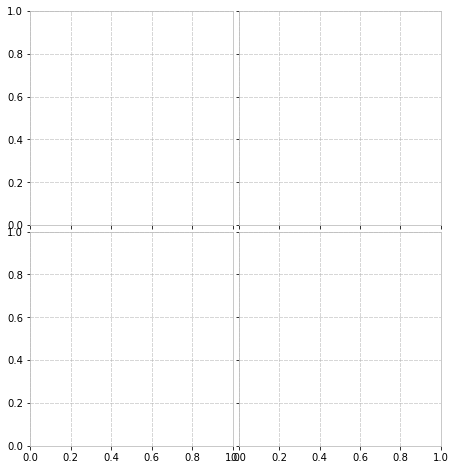

In [10]:
# plotting
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(7,8),constrained_layout=True,sharey=True,sharex=True)
plt.subplots_adjust(wspace=0.03,right=0.94,hspace=0.03)
fs = 12
plt.rcParams.update({'font.size':fs})
vmin = -1.5; vmax = 2; pivot = 0 
cmap = cmo.tools.crop(cmo.cm.balance, vmin, vmax, pivot) 

ll=0
for i in range(2):
    for j in range(2):
        # plot background and isopycnals
        ax[i,j].plot(np.ravel(sal_mean[:,0:328:inc,0:301:inc]),
                     np.ravel(temp_mean[:,0:328:inc,0:301:inc]),
                 color='lightgray',marker='.',linestyle='',markersize=1)
        ax[i,j].set_xlim(33.7,36.25)
        ax[i,j].set_ylim(13,32)
        #isopycnals
        cc = ax[i,j].contour(salm,tempm,dens,np.arange(10,30,1),colors='gray')
        ax[i,j].clabel(cc, fmt='%2.1f', colors='gray', fontsize=10)
        ax[i,j].grid()
        t = ax[i,j].text(0.02, 0.93, string.ascii_lowercase[ll]+')', transform=ax[i,j].transAxes, 
                size=11, weight='bold')
        t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))
        ll = ll+1

# NNI box
ax[0,0].scatter(np.ravel((k003f['vosaline'].sel(deptht=slice(0,depth))*bool_mhw).dropna(dim='time_counter')),
         np.ravel((k003f['votemper'].sel(deptht=slice(0,depth))*bool_mhw).dropna(dim='time_counter')),
         s=5,c=np.ravel((k003['votemper'].sel(deptht=slice(0,depth))*bool_mhw).dropna(dim='time_counter')),
         marker='o',cmap=cmap,zorder=10,
         vmin=-1.5,vmax=2)
cc = ax[0,1].scatter(np.ravel((k003f['vosaline'].sel(deptht=slice(0,depth))*bool_mcw).dropna(dim='time_counter')),
         np.ravel((k003f['votemper'].sel(deptht=slice(0,depth))*bool_mcw).dropna(dim='time_counter')),
         s=5,c=np.ravel((k003['votemper'].sel(deptht=slice(0,depth))*bool_mcw).dropna(dim='time_counter')),
         marker='o',cmap=cmap,zorder=10,
         vmin=-1.5,vmax=2)

# Leeuwin Current
ax[1,0].scatter(np.ravel((LC_k003['vosaline'].sel(deptht=slice(0,depth),lat=latrange)*bool_mhw).dropna(dim='time_counter')),
         np.ravel((LC_k003['votemper'].sel(deptht=slice(0,depth),lat=latrange)*bool_mhw).dropna(dim='time_counter')),
         s=5,c=np.ravel((LC_dseas['votemper'].sel(deptht=slice(0,depth),lat=latrange)*bool_mhw).dropna(dim='time_counter')),
         marker='o',cmap=cmap,zorder=10,
         vmin=-1.5,vmax=2)
cc = ax[1,1].scatter(np.ravel((LC_k003['vosaline'].sel(deptht=slice(0,depth),lat=latrange)*bool_mcw).dropna(dim='time_counter')),
         np.ravel((LC_k003['votemper'].sel(deptht=slice(0,depth),lat=latrange)*bool_mcw).dropna(dim='time_counter')),
         s=5,c=np.ravel((LC_dseas['votemper'].sel(deptht=slice(0,depth),lat=latrange)*bool_mcw).dropna(dim='time_counter')),
         marker='o',cmap=cmap,zorder=10,
         vmin=-1.5,vmax=2)

# axis properties
cbaxes = fig.add_axes([0.96, 0.25, 0.015, 0.5])
cb = plt.colorbar(cc, cax=cbaxes, orientation='vertical',label='temperature anomaly [\N{DEGREE SIGN}C]')
ax[1,0].set_xlabel('salinity [psu]')
ax[1,1].set_xlabel('salinity [psu]')
ax[0,0].set_ylabel('temperature [\N{DEGREE SIGN}C]')
ax[1,0].set_ylabel('temperature [\N{DEGREE SIGN}C]')
# ax[1].set_xlabel('salinity')
ax[0,0].set_title('Heatwaves',weight='bold')
ax[0,1].set_title('Cold spells',weight='bold')

# add text for rows
t = plt.text(0.51, 0.8, 'NNI', transform=plt.gcf().transFigure,
                size=12, weight='bold',zorder=10)
t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))
t = plt.text(0.43, 0.42, 'Leeuwin Current', transform=plt.gcf().transFigure,
                size=12, weight='bold',zorder=10)
t.set_bbox(dict(facecolor='w',boxstyle='square,pad=0.2'))

# plt.savefig(plotsave + 'fig6_ts_NNI_LC_mhw_mcw.png',dpi=300,bbox_inches='tight')